In [110]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import shap
# logistic regression
from sklearn.linear_model import LogisticRegression
# train test split
from sklearn.model_selection import train_test_split
# accuracy score
from sklearn.metrics import accuracy_score
# confusion matrix
from sklearn.metrics import confusion_matrix
# classification report
from sklearn.metrics import classification_report
# roc curve
from sklearn.metrics import roc_curve
# auc score
from sklearn.metrics import roc_auc_score

In [111]:
data=pd.read_csv('loans_2007.csv')
data=data[~data.revol_util.isna()]

In [112]:
data

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.0,1,860,27.65,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,15.27,59.83,0,30000.0,0,309,1.00,0.0,744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2400.0,15.96,84.33,10,12252.0,1,606,8.72,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000.0,13.49,339.31,10,49200.0,1,917,20.00,0.0,694.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5000.0,7.90,156.46,3,36000.0,1,852,11.20,0.0,734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39247,2500.0,8.07,78.42,4,110000.0,1,802,11.33,0.0,764.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39248,8500.0,10.28,275.38,3,18000.0,1,274,6.40,1.0,694.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39249,5000.0,8.07,156.84,0,100000.0,1,17,2.30,0.0,744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39250,5000.0,7.43,155.38,0,200000.0,1,208,3.72,0.0,814.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [113]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [114]:
# #use shap to explain the model's predictions
# explainer = shap.LinearExplainer(logreg, X_train, feature_perturbation="interventional")
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [115]:
# explainer = shap.LinearExplainer(logreg, X_train, feature_perturbation="correlation_dependent")
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

### NHANES - MORT (3.2)

In [204]:
nhanes = pd.read_csv('data/nhanes/nhanes_raw.csv',
                    low_memory=False, index_col=0)
nhanes

,ID,SurveyYr,Gender,Age,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,PregnantNow
1,51624,2009_10,male,34,409.0,White,NaN,High School,Married,25000-34999,...,16.0,8.0,1.0,No,Heterosexual,80100.543510,81528.772010,1,83,NaN
2,51625,2009_10,male,4,49.0,Other,NaN,NaN,NaN,20000-24999,...,NaN,NaN,NaN,NaN,NaN,53901.104290,56995.035430,2,79,NaN
3,51626,2009_10,male,16,202.0,Black,NaN,NaN,NaN,45000-54999,...,NaN,NaN,NaN,NaN,NaN,13953.078340,14509.278860,1,84,NaN
4,51627,2009_10,male,10,131.0,Black,NaN,NaN,NaN,20000-24999,...,NaN,NaN,NaN,NaN,NaN,11664.899400,12041.635370,2,86,NaN
5,51628,2009_10,female,60,722.0,Black,NaN,High School,Widowed,10000-14999,...,15.0,4.0,NaN,No,NaN,20090.339260,21000.338720,2,75,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20289,71912,2011_12,male,40,NaN,White,White,8th Grade,Married,25000-34999,...,14.0,15.0,15.0,No,Heterosexual,19633.637050,20770.138120,1,98,NaN
20290,71913,2011_12,female,18,NaN,Other,Asian,NaN,NaN,75000-99999,...,NaN,0.0,0.0,No,Heterosexual,7382.152016,8028.485773,1,94,NaN
20291,71914,2011_12,female,10,NaN,White,White,NaN,NaN,75000-99999,...,NaN,NaN,NaN,NaN,NaN,60197.256540,63931.531990,2,94,NaN
20292,71915,2011_12,male,60,NaN,White,White,College Grad,NeverMarried,65000-74999,...,19.0,2.0,NaN,No,NaN,88961.259220,91446.591980,3,90,NaN


#### 2009 mortality data

In [205]:
mort09 = pd.read_csv('data/nhanes/mort_nhanes_2009_2010.csv',
                    low_memory=False, index_col=0)
mort09 = mort09.rename(columns={'seqn': 'ID'})
mort09.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,51624,1,0.0,NaN,NaN,NaN,111.0,111.0
2,51625,2,NaN,NaN,NaN,NaN,NaN,NaN
3,51626,2,NaN,NaN,NaN,NaN,NaN,NaN
4,51627,2,NaN,NaN,NaN,NaN,NaN,NaN
5,51628,1,0.0,NaN,NaN,NaN,133.0,132.0


#### 2010 mortality data

In [206]:
mort11 = pd.read_csv('data/nhanes/mort_nhanes_2011_2012.csv',
                    low_memory=False, index_col=0)
mort11 = mort11.rename(columns={'seqn': 'ID'})
mort11.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,62161,1,0.0,NaN,NaN,NaN,93.0,92.0
2,62162,2,NaN,NaN,NaN,NaN,NaN,NaN
3,62163,2,NaN,NaN,NaN,NaN,NaN,NaN
4,62164,1,0.0,NaN,NaN,NaN,90.0,89.0
5,62165,2,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
mort = pd.concat([mort09, mort11], axis=0)
mort.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,51624,1,0.0,NaN,NaN,NaN,111.0,111.0
2,51625,2,NaN,NaN,NaN,NaN,NaN,NaN
3,51626,2,NaN,NaN,NaN,NaN,NaN,NaN
4,51627,2,NaN,NaN,NaN,NaN,NaN,NaN
5,51628,1,0.0,NaN,NaN,NaN,133.0,132.0


In [208]:
nhanes=nhanes.merge(mort, on='ID', how='outer')
# rm rows with Survey Year NaN
nhanes=nhanes[~nhanes['SurveyYr'].isna()]
# rm rows with Mortality Status NaN
nhanes=nhanes[~nhanes['mortstat'].isna()]
nhanes

,ID,SurveyYr,Gender,Age,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,SDMVPSU,SDMVSTRA,PregnantNow,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
0,51624,2009_10,male,34,409.0,White,NaN,High School,Married,25000-34999,...,1,83,NaN,1,0.0,NaN,NaN,NaN,111.0,111.0
4,51628,2009_10,female,60,722.0,Black,NaN,High School,Widowed,10000-14999,...,2,75,NaN,1,0.0,NaN,NaN,NaN,133.0,132.0
5,51629,2009_10,male,26,313.0,Mexican,NaN,9 - 11th Grade,Married,25000-34999,...,1,88,NaN,1,0.0,NaN,NaN,NaN,112.0,112.0
6,51630,2009_10,female,49,596.0,White,NaN,Some College,LivePartner,35000-44999,...,2,85,NaN,1,0.0,NaN,NaN,NaN,109.0,109.0
9,51633,2009_10,male,80,NaN,White,NaN,Some College,Married,15000-19999,...,1,77,NaN,1,0.0,NaN,NaN,NaN,124.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20285,71909,2011_12,male,28,NaN,Mexican,Mexican,9 - 11th Grade,NeverMarried,5000-9999,...,2,103,NaN,1,0.0,NaN,NaN,NaN,86.0,85.0
20287,71911,2011_12,male,27,NaN,Mexican,Mexican,College Grad,Married,75000-99999,...,2,102,NaN,1,0.0,NaN,NaN,NaN,97.0,96.0
20288,71912,2011_12,male,40,NaN,White,White,8th Grade,Married,25000-34999,...,1,98,NaN,1,0.0,NaN,NaN,NaN,95.0,95.0
20289,71913,2011_12,female,18,NaN,Other,Asian,NaN,NaN,75000-99999,...,1,94,NaN,1,0.0,NaN,NaN,NaN,91.0,90.0


In [241]:
ft= ['Age', 'BMI', 'HHIncomeMid', 'BPSysAve', 'Pulse']
ft_target = ['mortstat']
nhanes_train = nhanes[ft + ft_target]
nhanes_train = nhanes_train.dropna()
nhanes_train

,Age,BMI,HHIncomeMid,BPSysAve,Pulse,mortstat
0,34,32.22,30000.0,113.0,70.0,0.0
4,60,42.39,12500.0,150.0,72.0,0.0
5,26,32.61,30000.0,104.0,72.0,0.0
6,49,30.57,40000.0,112.0,86.0,0.0
9,80,26.04,17500.0,139.0,88.0,0.0
...,...,...,...,...,...,...
20285,28,29.40,7500.0,124.0,68.0,0.0
20287,27,31.30,87500.0,133.0,74.0,0.0
20288,40,27.90,30000.0,120.0,112.0,0.0
20289,18,21.60,87500.0,108.0,92.0,0.0


In [289]:
# split data into train and test sets
X = nhanes_train.drop('mortstat', axis=1)
y = nhanes_train['mortstat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [275]:
logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train.drop('BMI', axis=1), y_train)
y_pred = logreg.predict(X_test.drop('BMI', axis=1))
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8928


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


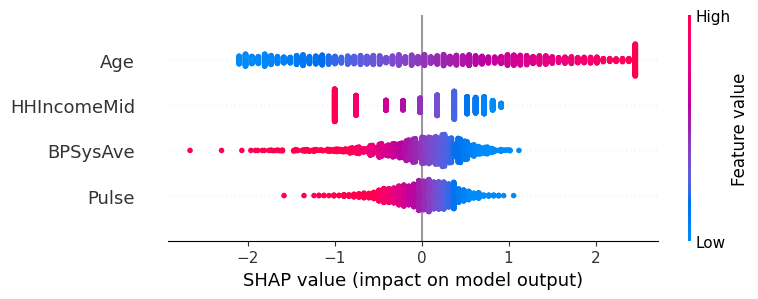

In [277]:
# interventional
explainer = shap.LinearExplainer(logreg, X_train.drop('BMI', axis=1), feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test.drop('BMI', axis=1))
shap.summary_plot(shap_values, X_test.drop('BMI', axis=1))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


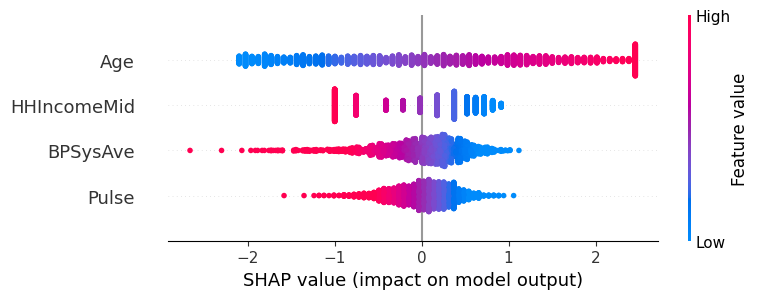

In [294]:
# interventional
explainer = shap.LinearExplainer(logreg, X_train.drop('BMI', axis=1), feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test.drop('BMI', axis=1))
shap.summary_plot(shap_values, X_test.drop('BMI', axis=1))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 3761.31it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


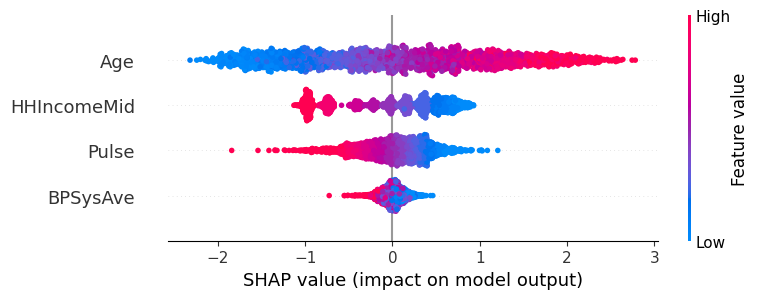

In [278]:
# correlation_dependent
explainer = shap.LinearExplainer(logreg, X_train.drop('BMI', axis=1), feature_perturbation="correlation_dependent")
shap_values = explainer.shap_values(X_test.drop('BMI', axis=1))
shap.summary_plot(shap_values, X_test.drop('BMI', axis=1))

In [301]:
# correlation_dependent
explainer = shap.LinearExplainer(logreg, X_train.drop('BMI', axis=1), feature_perturbation="correlation_dependent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 3864.99it/s]


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

### Lending club (4.1)

In [314]:
lc=pd.read_csv('data/loans_2007.csv', low_memory=False)

lc.dropna(axis=0, inplace=True)
lc.drop_duplicates(inplace=True)
lc.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.0,1,860,27.65,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,15.27,59.83,0,30000.0,0,309,1.00,0.0,744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2400.0,15.96,84.33,10,12252.0,1,606,8.72,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000.0,13.49,339.31,10,49200.0,1,917,20.00,0.0,694.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5000.0,7.90,156.46,3,36000.0,1,852,11.20,0.0,734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [316]:
X = lc.drop('loan_status', axis=1)
y = lc['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8804


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


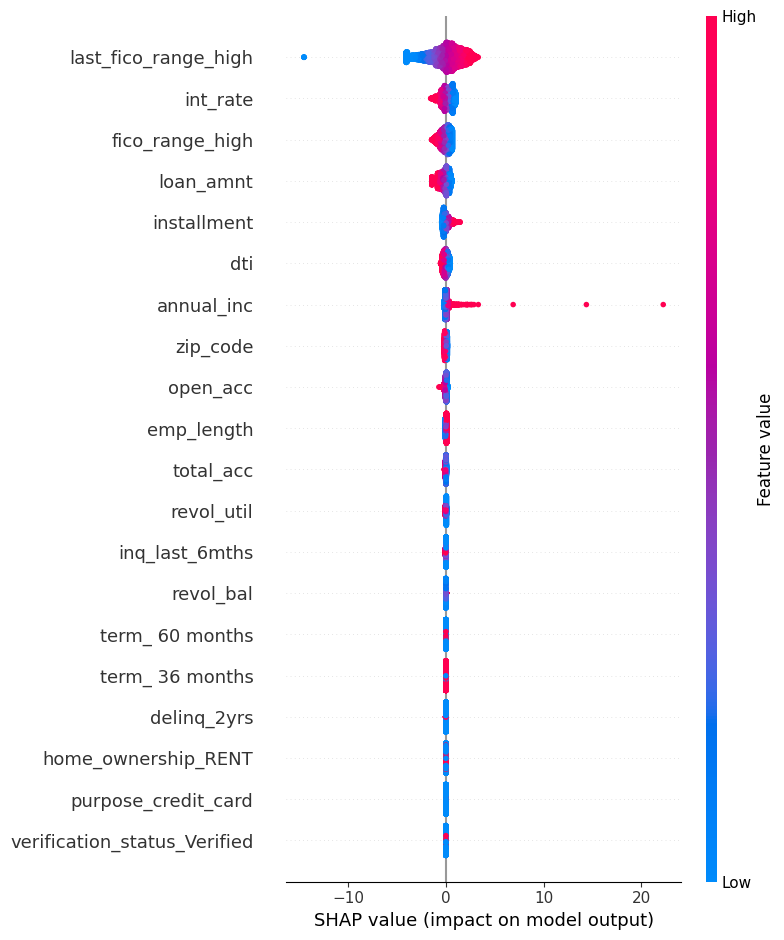

In [317]:
explainer = shap.LinearExplainer(logreg, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

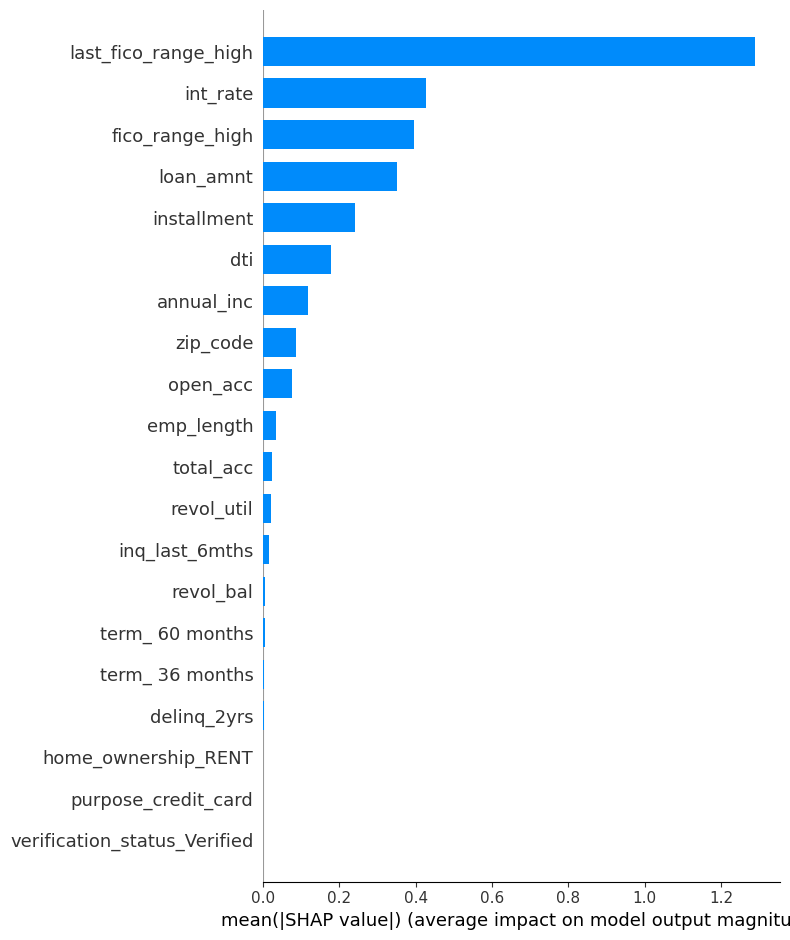

In [318]:
shap.summary_plot(shap_values, X_test, plot_type="bar")